In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from surprisal_utils import compute_log_frequency, exclude_token, prev_token_predictors
from analysis_utils import run_crossval, format_logliks, fit_gam 
sns.set_theme()
sns.set_palette("colorblind")

# Data Preprocessing

In [41]:
ns_rts = pd.read_table("natural_stories_rts.tsv", sep = "\t")
ns_surprisal = pd.read_table("ns_rnn.tsv", sep = "\t")
ns_tpc = pd.read_csv("natural_stories_metrics_linear_0_512_new.csv")

In [3]:
ns_rts.head()

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT
0,A3QJPB0NZU5PY1,3960,6,1,1,637,If,84,578.964286,276.061345,527.81264,1.524238
1,A2RPQGUWVZPX7U,2431,5,1,1,1222,If,84,578.964286,276.061345,527.81264,1.524238
2,A11KMPAZSE5Q0Q,1287,5,1,1,416,If,84,578.964286,276.061345,527.81264,1.524238
3,A1U1QL617G5DU3,2074,6,1,1,571,If,84,578.964286,276.061345,527.81264,1.524238
4,ACTW5YEWV9OR0,2213,6,1,1,1208,If,84,578.964286,276.061345,527.81264,1.524238


In [4]:
ns_surprisal.head()

,word,sentid,sentpos,wlen,surp,entropy,entred
0,If,0,0,2,10.248306,5.634664,0.000000
1,you,0,1,3,7.058940,5.231227,0.403437
2,were,0,2,4,3.672294,7.170536,0.000000
3,to,0,3,2,5.858786,8.976997,0.000000
4,journey,0,4,7,17.379740,7.208412,1.768585


In [5]:
ns_tpc.head()

,Unnamed: 0,token,RT,brown_bigram_surprisal,length,index,free_energy,arclength,amplitude,li_top_down,...,wnorm_xx,bnorm_x,bnorm_y,cosdist_y,cosdist_prior_v_posterior,cosdist_posterior_v_posterior,cosdist_likelihood_v_posterior,bayesian_surprise,iters,model_token
0,0,If,369.011905,1.914162,2,0,375.016510,0.880681,5.637548,0.592878,...,0.338693,0.485173,0.258339,0.507138,0.153830,1.002278,0.582389,36.162292,349,if
1,1,you,368.183908,0.987995,3,1,374.975616,0.520381,2.242520,0.199160,...,0.160373,0.379716,0.174865,0.344078,0.229773,0.854273,0.414032,36.139481,330,you
2,2,were,344.318182,1.721557,4,2,374.990692,0.475426,4.293675,0.043788,...,0.130094,0.442103,0.187409,0.442977,0.378069,0.936419,0.265883,36.152298,303,were
3,3,to,354.639535,1.574903,2,3,374.957733,0.429041,4.000612,0.069285,...,0.094578,0.336446,0.101356,0.300196,0.291088,0.917132,0.236109,36.131744,301,to
4,4,journey,349.674157,4.775415,7,4,375.079498,0.446789,4.031974,-0.026358,...,0.143135,0.600270,0.360943,0.670735,0.603879,0.865874,0.191918,36.193527,293,journey


In [6]:
ns_tpc.columns

Index(['Unnamed: 0', 'token', 'RT', 'brown_bigram_surprisal', 'length',
       'index', 'free_energy', 'arclength', 'amplitude', 'li_top_down',
       'li_bottom_up', 'wnorm_xy', 'wnorm_xx', 'bnorm_x', 'bnorm_y',
       'cosdist_y', 'cosdist_prior_v_posterior',
       'cosdist_posterior_v_posterior', 'cosdist_likelihood_v_posterior',
       'bayesian_surprise', 'iters', 'model_token'],
      dtype='object')

In [7]:
len(ns_surprisal.index)

10256

In [8]:
len(ns_tpc.index)

10256

Correcting an error with the Natural Stories corpus' RTs.

In [53]:
average_rts = ns_rts[["word", "meanItemRT"]].drop_duplicates()
ns_tpc['RT'] = average_rts['meanItemRT'].values
ns_tpc

,Unnamed: 0,token,RT,brown_bigram_surprisal,length,index,free_energy,arclength,amplitude,li_top_down,...,wnorm_xx,bnorm_x,bnorm_y,cosdist_y,cosdist_prior_v_posterior,cosdist_posterior_v_posterior,cosdist_likelihood_v_posterior,bayesian_surprise,iters,model_token
0,0,If,578.964286,1.914162,2,0,375.016510,0.880681,5.637548,0.592878,...,0.338693,0.485173,0.258339,0.507138,0.153830,1.002278,0.582389,36.162292,349,if
1,1,you,369.011905,0.987995,3,1,374.975616,0.520381,2.242520,0.199160,...,0.160373,0.379716,0.174865,0.344078,0.229773,0.854273,0.414032,36.139481,330,you
2,2,were,368.183908,1.721557,4,2,374.990692,0.475426,4.293675,0.043788,...,0.130094,0.442103,0.187409,0.442977,0.378069,0.936419,0.265883,36.152298,303,were
3,3,to,344.318182,1.574903,2,3,374.957733,0.429041,4.000612,0.069285,...,0.094578,0.336446,0.101356,0.300196,0.291088,0.917132,0.236109,36.131744,301,to
4,4,journey,354.639535,4.775415,7,4,375.079498,0.446789,4.031974,-0.026358,...,0.143135,0.600270,0.360943,0.670735,0.603879,0.865874,0.191918,36.193527,293,journey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,10251,and,323.585714,1.768994,3,10251,374.954010,0.454728,4.161006,0.112521,...,0.107635,0.306525,0.111450,0.231185,0.197341,0.771089,0.322825,36.126923,295,and
10252,10252,better,317.414286,3.278222,6,10252,375.011017,0.411780,3.618856,0.024477,...,0.115224,0.451899,0.267116,0.322928,0.423757,0.836014,0.266328,36.154495,296,better
10253,10253,treatments,335.267606,4.996149,10,10253,375.114166,0.461616,3.408972,-0.010898,...,0.171987,0.622108,0.431607,0.723463,0.573477,0.843851,0.206595,36.200195,292,treatments
10254,10254,for,359.861111,2.387349,3,10254,374.982635,0.479495,3.953347,0.100014,...,0.142096,0.413960,0.176007,0.313459,0.296587,0.837442,0.287841,36.146286,301,for


In [54]:
predictor_names = ['rnn_surprisal', 'brown_bigram_surprisal', 'iters', 'arclength',
 'li_bottom_up',
 'li_top_down',
 'free_energy',
 'wnorm_xy',
 'wnorm_xx',
 'cosdist_y',
 'cosdist_prior_v_posterior',
 'cosdist_likelihood_v_posterior',
 'bayesian_surprise']

In [55]:
ns_predictors = ns_tpc.merge(ns_surprisal, right_index=True, left_index=True)
ns_predictors['log_freq'] = ns_predictors['token'].apply(compute_log_frequency, language = "en")
ns_predictors.rename({"wlen" : "word_length", "surp" : "rnn_surprisal"}, axis = 1, inplace=True)

/Users/sathvik/Desktop/umd/predictive-coding/surprisal_utils.py:17: RuntimeWarning: divide by zero encountered in log2
  return -np.log2(freq)


In [56]:
ns_predictors['exclude'] = [exclude_token(ns_predictors, i, 'token') for i in range(len(ns_predictors.index))]

In [57]:
ns_predictors

,Unnamed: 0,token,RT,brown_bigram_surprisal,length,index,free_energy,arclength,amplitude,li_top_down,...,model_token,word,sentid,sentpos,word_length,rnn_surprisal,entropy,entred,log_freq,exclude
0,0,If,578.964286,1.914162,2,0,375.016510,0.880681,5.637548,0.592878,...,if,If,0,0,2,10.248306,5.634664,0.000000,8.405069,0
1,1,you,369.011905,0.987995,3,1,374.975616,0.520381,2.242520,0.199160,...,you,you,0,1,3,7.058940,5.231227,0.403437,6.710284,0
2,2,were,368.183908,1.721557,4,2,374.990692,0.475426,4.293675,0.043788,...,were,were,0,2,4,3.672294,7.170536,0.000000,8.834853,0
3,3,to,344.318182,1.574903,2,3,374.957733,0.429041,4.000612,0.069285,...,to,to,0,3,2,5.858786,8.976997,0.000000,5.216250,0
4,4,journey,354.639535,4.775415,7,4,375.079498,0.446789,4.031974,-0.026358,...,journey,journey,0,4,7,17.379740,7.208412,1.768585,14.449366,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,10251,and,323.585714,1.768994,3,10251,374.954010,0.454728,4.161006,0.112521,...,and,and,505,11,3,3.461546,4.446274,3.624925,5.282088,0
10252,10252,better,317.414286,3.278222,6,10252,375.011017,0.411780,3.618856,0.024477,...,better,better,505,12,6,12.226772,9.968488,0.000000,10.764150,0
10253,10253,treatments,335.267606,4.996149,10,10253,375.114166,0.461616,3.408972,-0.010898,...,treatments,treatments,505,13,10,13.178303,9.741071,0.227417,16.310982,0
10254,10254,for,359.861111,2.387349,3,10254,374.982635,0.479495,3.953347,0.100014,...,for,for,505,14,3,5.047508,5.159407,4.581664,6.615287,1


In [58]:
ns_predictors = ns_predictors[(ns_predictors['exclude'] == 0)]
ns_predictors.replace([np.inf, -np.inf], np.nan, inplace=True)
ns_predictors = ns_predictors.dropna()

/var/folders/23/7hcv_qtd60j5mx97z8mfdjgh0000gn/T/ipykernel_37702/3148699688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ns_predictors.replace([np.inf, -np.inf], np.nan, inplace=True)


In [59]:
len(ns_predictors.index)

6619

# Computing Psychometric Predictive Power

In [60]:
np.random.seed(84)

In [61]:
cv = KFold(n_splits=10, shuffle=True)
cv_split = cv.split(np.array(ns_predictors))
indices = []
for train_indices, test_indices in cv_split:
    indices.append((train_indices, test_indices))

In [62]:
gam_ppp = run_crossval(indices, ns_predictors, predictor_names, 0, is_linear = False)

Running 10-fold CV for rnn_surprisal
Average Delta LogLik: 0.0030471370376458752
Running 10-fold CV for brown_bigram_surprisal
Average Delta LogLik: 0.0035861377594343935
Running 10-fold CV for iters
Average Delta LogLik: 0.03094164268746873
Running 10-fold CV for arclength
Average Delta LogLik: 0.03324737640975588
Running 10-fold CV for li_bottom_up
Average Delta LogLik: 0.001339016612500732
Running 10-fold CV for li_top_down
Average Delta LogLik: 0.04678327089555516
Running 10-fold CV for free_energy
Average Delta LogLik: 0.004392804792369453
Running 10-fold CV for wnorm_xy
Average Delta LogLik: 0.012756653915558224
Running 10-fold CV for wnorm_xx
Average Delta LogLik: 0.04677044714189806
Running 10-fold CV for cosdist_y
Average Delta LogLik: 0.004352745358794685
Running 10-fold CV for cosdist_prior_v_posterior
Average Delta LogLik: 0.014517448217581119
Running 10-fold CV for cosdist_likelihood_v_posterior
Average Delta LogLik: 0.027620159523299038
Running 10-fold CV for bayesian_sur

In [63]:
tpc_delta_loglik = pd.DataFrame(gam_ppp)

melted_loglik = format_logliks(tpc_delta_loglik)

Text(0.5, 1.0, 'Psychometric Predictive Power (Natural Stories)')

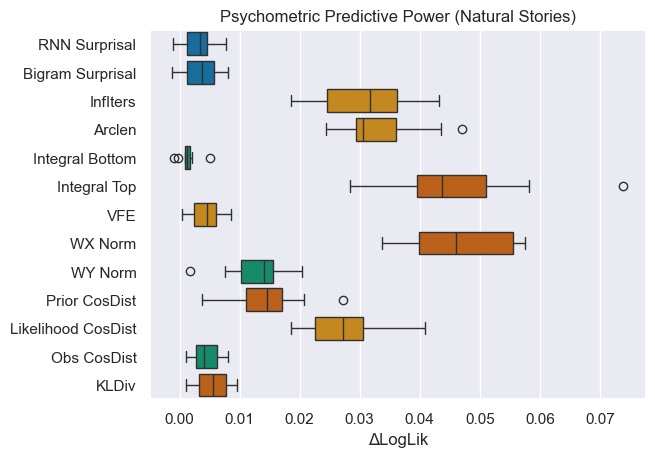

In [64]:
sns.boxplot(data = melted_loglik, x = "value", y = "predictor_name", hue = "metric_type", legend=False,
            order=["RNN Surprisal", "Bigram Surprisal",
                   "InfIters", "Arclen", "Integral Bottom", "Integral Top", "VFE", "WX Norm",
                   "WY Norm", "Prior CosDist", "Likelihood CosDist", "Obs CosDist", "KLDiv"])
plt.xlabel("ΔLogLik")
plt.ylabel("")
plt.title("Psychometric Predictive Power (Natural Stories)")

# Statistical Tests

In [77]:
from analysis_utils import significance_table, compare_with_surprisal, significance_surprisal

In [78]:
significance_table(tpc_delta_loglik)

,predictor_name,stat,p_value,significance
0,rnn_surprisal,53.0,0.002930,**
1,brown_bigram_surprisal,52.0,0.004883,**
2,iters,55.0,0.000977,***
3,arclength,55.0,0.000977,***
4,li_bottom_up,52.0,0.004883,**
5,li_top_down,55.0,0.000977,***
6,free_energy,55.0,0.000977,***
7,wnorm_xy,55.0,0.000977,***
8,wnorm_xx,55.0,0.000977,***
9,cosdist_y,55.0,0.000977,***


Checking for whether a predictor was better than surprisal

In [79]:
tpc_predictors = predictor_names[2:]

vs_bigram, vs_rnn = compare_with_surprisal(tpc_delta_loglik, tpc_predictors, "greater")

significance_surprisal(vs_rnn)

,predictor,gam_effect,gam_p,gam_significance
0,iters,55.0,0.000977,***
1,arclength,55.0,0.000977,***
2,li_bottom_up,8.0,0.981445,None
3,li_top_down,55.0,0.000977,***
4,free_energy,36.0,0.215820,None
5,wnorm_xy,54.0,0.001953,**
6,wnorm_xx,55.0,0.000977,***
7,cosdist_y,35.0,0.246094,None
8,cosdist_prior_v_posterior,54.0,0.001953,**
9,cosdist_likelihood_v_posterior,55.0,0.000977,***


In [80]:
significance_surprisal(vs_bigram)

,predictor,gam_effect,gam_p,gam_significance
0,iters,55.0,0.000977,***
1,arclength,55.0,0.000977,***
2,li_bottom_up,4.0,0.995117,None
3,li_top_down,55.0,0.000977,***
4,free_energy,32.0,0.347656,None
5,wnorm_xy,52.0,0.004883,**
6,wnorm_xx,55.0,0.000977,***
7,cosdist_y,33.0,0.312500,None
8,cosdist_prior_v_posterior,54.0,0.001953,**
9,cosdist_likelihood_v_posterior,55.0,0.000977,***


Seeing which predictors were comparable with surprisal

In [81]:
vs_bigram, vs_rnn = compare_with_surprisal(tpc_delta_loglik, tpc_predictors)
significance_surprisal(vs_rnn)

,predictor,gam_effect,gam_p,gam_significance
0,iters,0.0,0.001953,**
1,arclength,0.0,0.001953,**
2,li_bottom_up,8.0,0.048828,*
3,li_top_down,0.0,0.001953,**
4,free_energy,19.0,0.431641,None
5,wnorm_xy,1.0,0.003906,**
6,wnorm_xx,0.0,0.001953,**
7,cosdist_y,20.0,0.492188,None
8,cosdist_prior_v_posterior,1.0,0.003906,**
9,cosdist_likelihood_v_posterior,0.0,0.001953,**


In [82]:
significance_surprisal(vs_bigram)

,predictor,gam_effect,gam_p,gam_significance
0,iters,0.0,0.001953,**
1,arclength,0.0,0.001953,**
2,li_bottom_up,4.0,0.013672,*
3,li_top_down,0.0,0.001953,**
4,free_energy,23.0,0.695312,None
5,wnorm_xy,3.0,0.009766,**
6,wnorm_xx,0.0,0.001953,**
7,cosdist_y,22.0,0.625000,None
8,cosdist_prior_v_posterior,1.0,0.003906,**
9,cosdist_likelihood_v_posterior,0.0,0.001953,**


Fitting model for free_energy
15.320525828946765
Fitting model for cosdist_y
23.208690070722636
Fitting model for rnn_surprisal
17.981238711987604
Fitting model for brown_bigram_surprisal
14.482940442937846


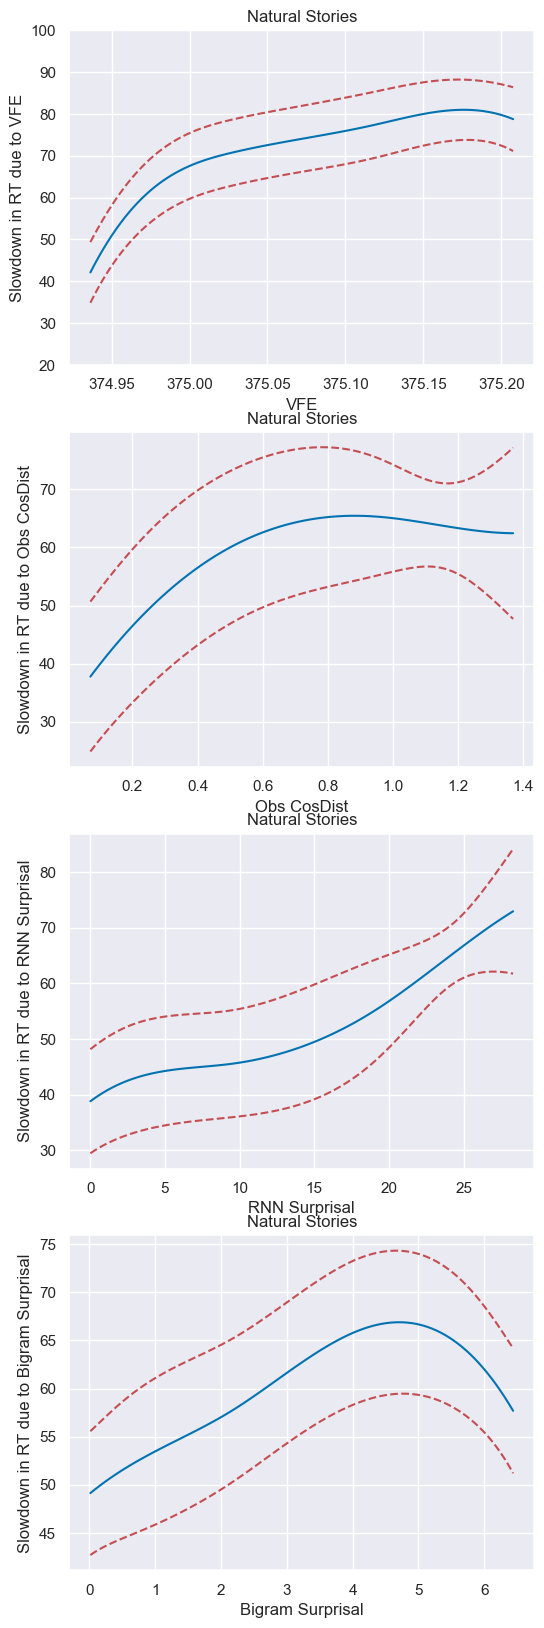

In [89]:
surprisal_like = ['free_energy', 'cosdist_y', 'rnn_surprisal', 'brown_bigram_surprisal']
plot_labels = ["VFE", "Obs CosDist", 'RNN Surprisal', "Bigram Surprisal"]
bounds = [(20, 100), (None, None), (None, None), (None, None)]

fig, axs = plt.subplots(len(surprisal_like), figsize = (6, 20), sharex=False)
for i in range(len(surprisal_like)):
    predictor = surprisal_like[i]
    print(f"Fitting model for {predictor}")
    model = fit_gam(ns_predictors, predictor, 0, False, False, False)
    plot_gam(model, ns_predictors[predictor], plot_labels[i], axs[i], bounds[i], "Natural Stories")
